In [1]:
'''Some generic python and jupyter imports'''
import numpy as np
from numpy import pi,sqrt

'''Qiskit imports - Updated for Qiskit 1.0+'''
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator

'''Visualizations'''
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

# Create simulator instances
backend_svec = AerSimulator(method='statevector')
backend_qasm = AerSimulator()

## Problem Set 6: Error Correction in Qiskit

In this problem set, you will implement a 3-qubit repetition code that can correct one bit-flip error. We will do this in three steps:
1. model a bit-flip channel by introduing an environment qubit
2. implement the 3-qubit repetition code and its error correction ciruit
3. plug the bit-flip channel into the code and test its performance against the bit flip

Importantly, this is not a actual quantum error correcting code! repetition codes are prone to phase-flip error on even a single qubit. FYI The smallest quantum error correcting code that corrects arbitrary one-qubit error is called [5,1,3] code and it has five qubits.

### Part 1: Implementing the bit-flip channel

A bit flip channel flips a qubit by apply $X$ with some probability $p$, so we will use another qubit called the environment qubit to flip the coin. Here's what we will do:

1. Initialze the enrivonment qubit to $\alpha \vert 0 \rangle_e + \beta \vert 1 \rangle_e$, where $\alpha,\beta$ will be decided by the probability $p$.
2. Apply a CNOT controlled by the enrivonment qubit and acting on the code qubit that we want to impose the channel.
3. Throw away the environment. Mathematically this would correspond to tracing it out, and physically we will just leave it there and never touch it again.

1(a)
Let's say the environment qubit is initialized to $\alpha \vert 0 \rangle_e + \beta \vert 1 \rangle_e$, and the target code qubit has the density matrix $\rho_c$. Write down the state (1) after applying the CNOT gate and (2) after tracing out the environment

8i88itype your solution here or submit a separate PDF file

1(b) The bit flip channel can be written as:

$E_{bf}[\rho_c] = (1-p)\rho_c + p X \rho_c X$

By identifying what you have gotten in 1(a) to the bit-flip channel, what's the value of $\alpha$ and $\beta$?

type your solution here or submit a separate PDF file

1 (c) now we are ready to implement the bit-flip channel. We initialize the code qubit to $\vert 0 \rangle_c$.

Hint: to initialize the environment_qubit one operation is "ry(theta, qubit)". Check the qiskit document for its definition. Beware that you will input a rotation angle but the actual angle to be rotated is theta/2 !

In [3]:
# define the code and environment qubits
import math as math
code_qubit = QuantumRegister(1,'code_qubit')
environment_qubit = QuantumRegister(1,'environment_qubit')
# this is a classical register to store the measurement outcome
code_meas = ClassicalRegister(1,'code_meas') 

# for the first run set p=0.1
# but feel free to explore other values!
p = 0.1
angle = math.asin(math.sqrt(0.1))
print(angle)
# generate the circuit instance
noisy_circuit = QuantumCircuit(code_qubit,environment_qubit,code_meas)

####### implement the channel here #########
noisy_circuit.ry(2*angle,environment_qubit[0])
noisy_circuit.cx(environment_qubit[0],code_qubit[0])
############################################

# to characterize the bit flip we will measure it in the computational basis
noisy_circuit.measure(code_qubit,code_meas)

0.3217505543966422


Try to run the circuit for one particular value $p=0.1$ and plot the histogram

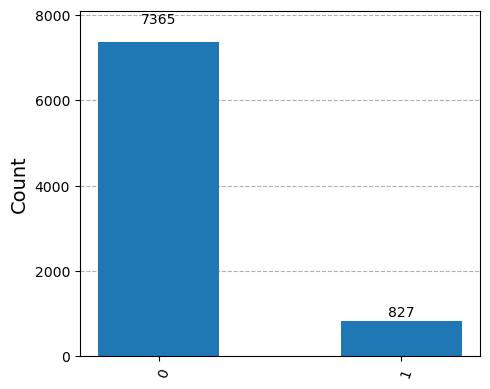

In [4]:
# Simulate your circuit. 2**13 shots should be sufficient
transpiled_circuit = transpile(noisy_circuit, backend_qasm)
job = backend_qasm.run(transpiled_circuit, shots=2**13)
# Get results using the .result().get_counts() function
counts = job.result().get_counts()
# plot the result
plot_histogram(counts, figsize=(5, 4))

1(d) Now we will do the same thing but scan the value of p from zero to one. Generate a plot of P(0) at different values of p, where P(0) is the probability of measuring $\vert 0 \rangle$

Hint: you know the value of P(0) at p=0 and p=1 automatically

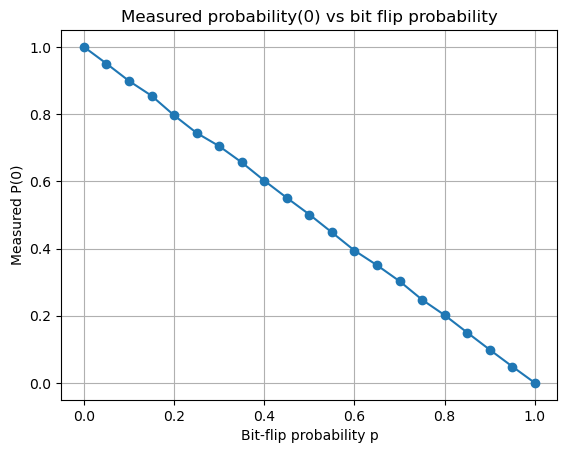

In [32]:

import matplotlib.pyplot as plt

def bit_flip_channel(theta):
    code_qubit = QuantumRegister(1,'code_qubit')
    environment_qubit = QuantumRegister(1,'environment_qubit')
    # this is a classical register to store the measurement outcome
    code_meas = ClassicalRegister(1,'code_meas') 

    # for the first run set p=0.1
    # but feel free to explore other values!
    # generate the circuit instance
    noisy_circuit = QuantumCircuit(code_qubit,environment_qubit,code_meas)

    ####### implement the channel here #########
    noisy_circuit.ry(2*theta,environment_qubit[0])
    noisy_circuit.cx(environment_qubit[0],code_qubit[0])
    ############################################

    # to characterize the bit flip we will measure it in the computational basis
    noisy_circuit.measure(code_qubit,code_meas)

    return noisy_circuit

probs_1 = []
shots=2**13
p_values = np.linspace(0, 1, 21)
for p in p_values:
    theta = math.asin(math.sqrt(p))
    circuit = bit_flip_channel(theta)
    transpiled = transpile(circuit, backend)
    job = backend.run(transpiled, shots=shots)
    counts = job.result().get_counts()

    p1 = counts.get('0', 0) / shots
    probs_1.append(p1)

plt.plot(p_values, probs_1, marker='o')
plt.xlabel("Bit-flip probability p")
plt.ylabel("Measured P(0)")
plt.title("Measured probability(0) vs bit flip probability")
plt.grid()
plt.show()



### Part 2: Implementing the repetition code

In this section we will implement the repetition code. The code state will look like:

 $\alpha \vert 000 \rangle + \beta \vert 111 \rangle$

 Where $\alpha$ and $\beta$ store the code information. Since the repetition code cannot protect the phase information, we will make $\alpha$ and $\beta$ positive and only worry about there absolute values. To make things consistent throughout this assignment, we will set $\alpha=cos(\pi /8)$ and $\beta=sin(\pi /8)$.

2(a): construct the code state using single-qubit rotation ry(theta,qubit) and CNOT gate. We have to define all the qubits here but for this question we will only touch the code qubits "cq" which store the code.

Hint: CNOT maps $\vert 00 \rangle$ to $\vert 00 \rangle$ and maps $\vert 10 \rangle$ to $\vert 11 \rangle$. In other words, when the value of the second qubit is 0, CNOT copies the value of the first qubit to the second qubit.

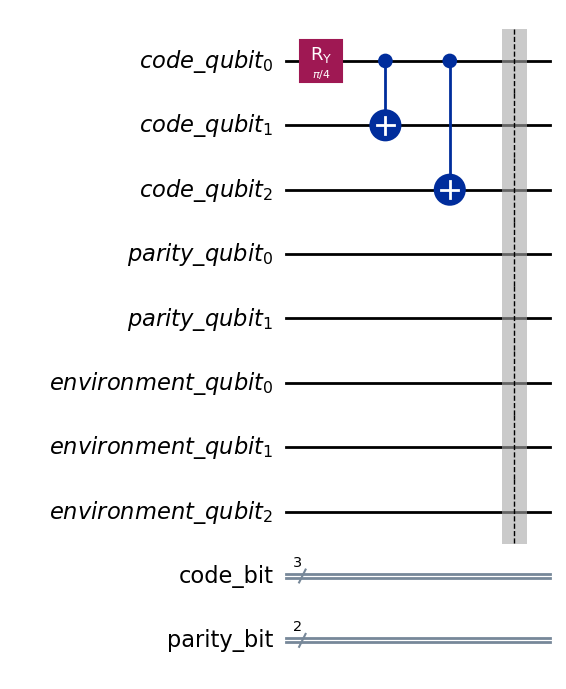

In [13]:
# code qubits and the corresponding classical bits to store measurement outcome
cq = QuantumRegister(3,'code_qubit')
cb = ClassicalRegister(3,'code_bit')
# parity check qubits and the corresponding classical bits to store measurement outcome
pq = QuantumRegister(2,'parity_qubit')
pb = ClassicalRegister(2,'parity_bit')
# environment qubits for the bit-flip channel
eq = QuantumRegister(3,'environment_qubit')

init_circ = QuantumCircuit(cq,cb,pq,pb,eq)

###### implement the code generation circuit here ######
init_circ.ry(math.pi/4,cq[0])
init_circ.cx(cq[0],cq[1])
init_circ.cx(cq[0],cq[2])

########################################################
init_circ.barrier()

init_circ.draw('mpl')

After constructing the code state, we will implement the error detection. For this part, we will introduce two additional parity qubits "pq" and two classical bits "pb" to store the measurement outcome. "pq[0]" will check the parity information between "cq[0]" and "cq[1]". For example, if "cq[0]" and "cq[1]" are in $\vert 00 \rangle$ or $\vert 11 \rangle$, "pq[0]" should be $\vert 0 \rangle$. If "cq[0]" and "cq[1]" are in $\vert 01 \rangle$ or $\vert 10 \rangle$, "pq[0]" should be $\vert 1 \rangle$. Similarly, "pq[1]" will check the parity information between "cq[1]" and "cq[2]". After doing the parity check, we will measure "pq" and store the values in "pb". This can be done with somthing like "check_circ.measure(pq[0],pb[0])"

2(b) Implement the parity check circuit and the subsequent measurement.

Hint: CNOT is all you need for the parity check. I already gave you the measurement command.

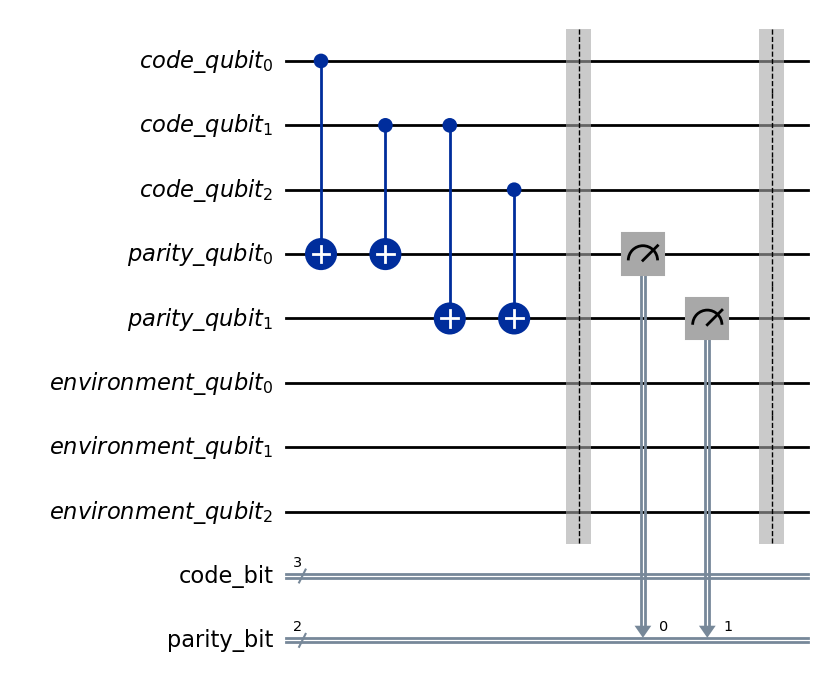

In [16]:
check_circ = QuantumCircuit(cq,cb,pq,pb,eq)

###### implement the parity check here ######
check_circ.cx(cq[0],pq[0])
check_circ.cx(cq[1],pq[0])

check_circ.cx(cq[1],pq[1])
check_circ.cx(cq[2],pq[1])

#############################################

check_circ.barrier()

###### implement the measurement here ######

check_circ.measure(pq[0],pb[0])
check_circ.measure(pq[1],pb[1])
#############################################
check_circ.barrier()

check_circ.draw('mpl')

We have checked the parity, so now let's error correct. If there's nothing wrong with the code, both parity checks should give zero. However, if one code qubit is accidentally flipped, then some parity checks will become 1.

2(c) Given that only one qubit is flipped, figure out which one is flipped given the parity outcome in the table below 

Fill in the table

00: all good!

01:qubit 3 is flipped

10:qubit 1 is flipped

11:qubit 2 is flipped

Now we know which qubit is flipped, we can correct it by applying a X gate conditioned on the parity outcome. **Note for Qiskit 1.0+:** The syntax for conditional operations has changed from `c_if` to `if_test`. The new syntax uses context managers:

```python
# Old syntax (deprecated): qc.x(qubit).c_if(register, value)
# New syntax: 
with qc.if_test((register, value)):
    qc.x(qubit)
```

Where the register is the classical register (like pb), and the value is the corresponding parity outcome in decimal. For example. 10 would be 2 and 11 would be 3.

2(d) implement the error correction circuit

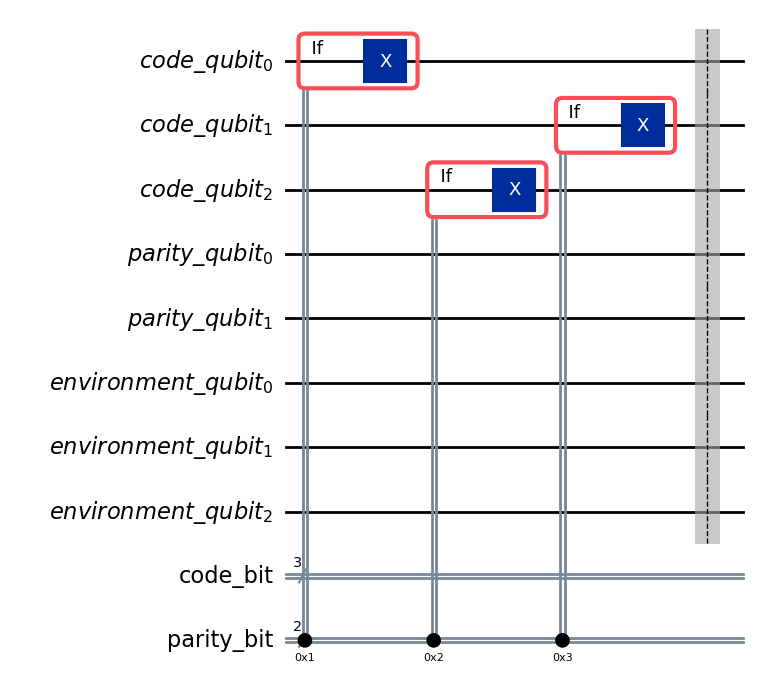

In [45]:
feedback_circ = QuantumCircuit(cq,cb,pq,pb,eq)

###### implement the error correction here ######

with feedback_circ.if_test((pb,1)):
    feedback_circ.x(cq[0])
with feedback_circ.if_test((pb,2)):
    feedback_circ.x(cq[2])
with feedback_circ.if_test((pb,3)):
    feedback_circ.x(cq[1])

#################################################
feedback_circ.barrier()

feedback_circ.draw('mpl')

Finally we would like to measure the code qubits "cq" and store the outcome in "cb" so that we can check if we have successfully performed the error correction.

2(e) implement the final code qubit measurement 

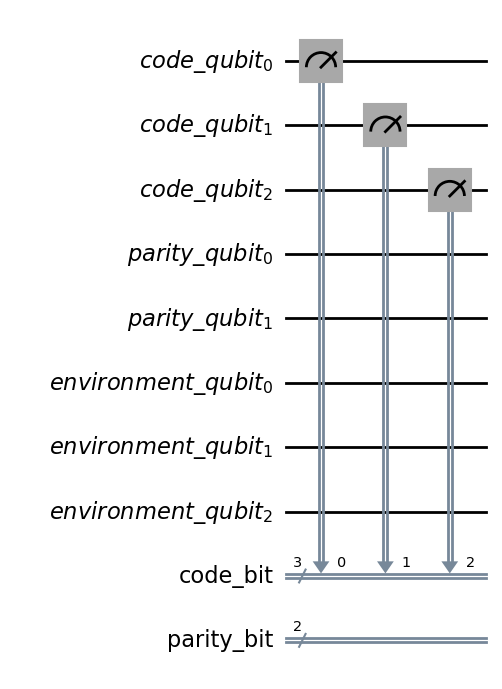

In [46]:
final_circ = QuantumCircuit(cq,cb,pq,pb,eq)

###### implement the final measurement here ######

final_circ.measure(cq[0],cb[0])
final_circ.measure(cq[1],cb[1])
final_circ.measure(cq[2],cb[2])
#################################################


final_circ.draw('mpl')

Now we can assemble the circuit! Run run the code below to see how it looks like

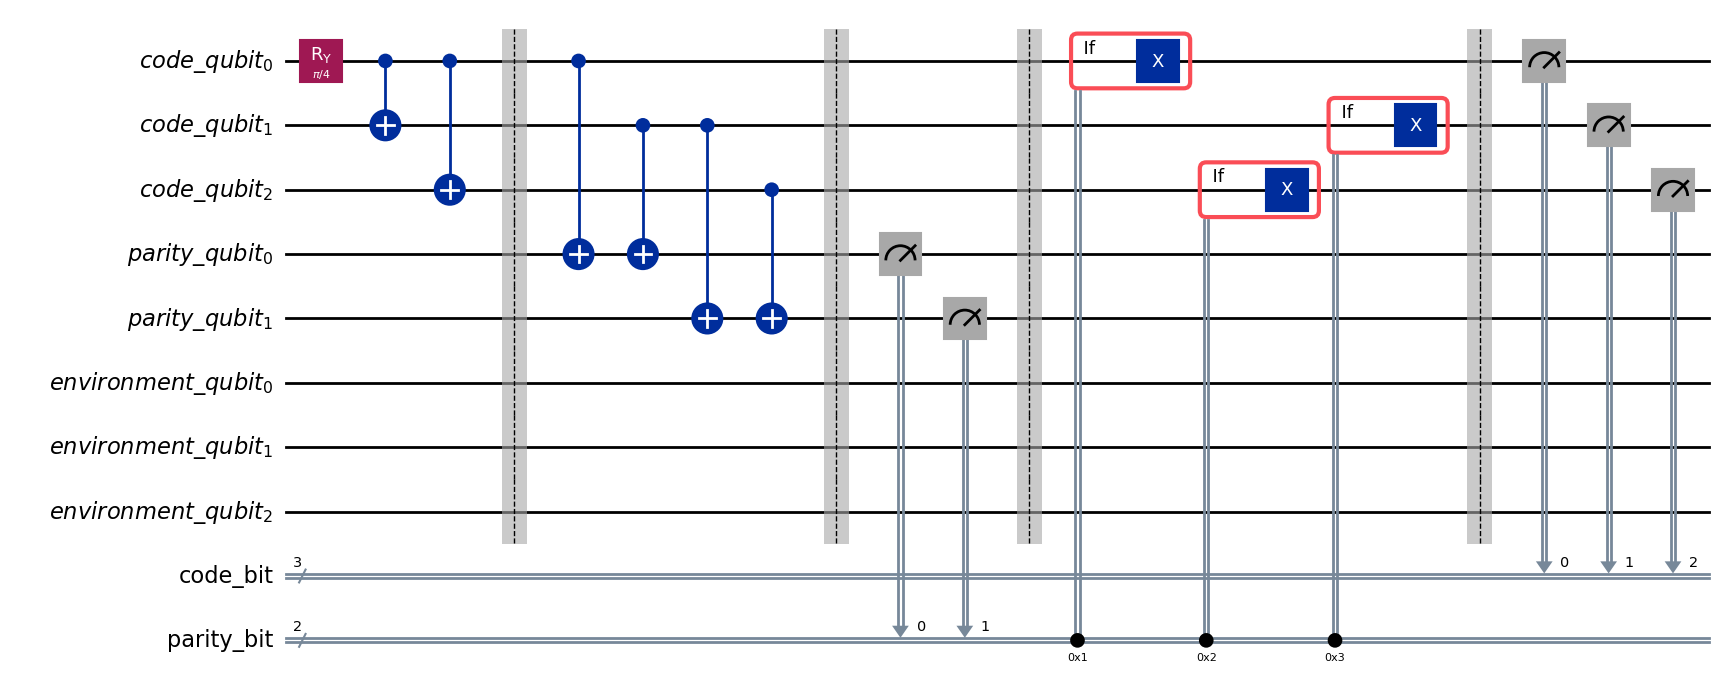

In [47]:
# compose the circuit
circuit = init_circ.compose(check_circ)
circuit = circuit.compose(feedback_circ)
circuit = circuit.compose(final_circ)

circuit.draw('mpl')

We will run this circuit and look at the histogram of the measurement outcome. Run the code below. If everything works correctly, you should only see "00 000" around 7000 times and "00 111" around 1200 times

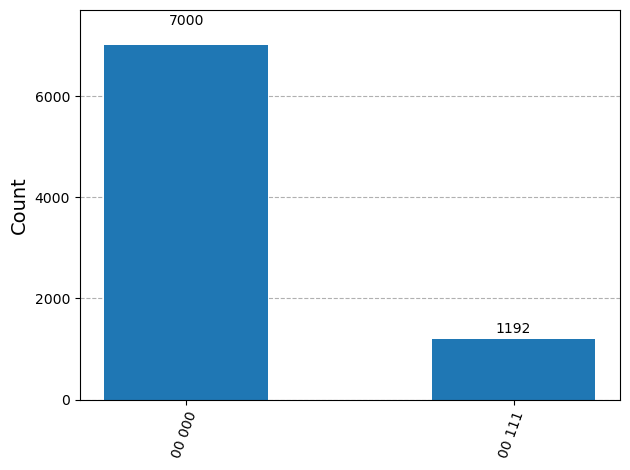

In [48]:
# compose the circuit
circuit = init_circ.compose(check_circ)
circuit = circuit.compose(feedback_circ)
circuit = circuit.compose(final_circ)

# Simulate your circuit. 1024 shots should be sufficient
transpiled_circuit = transpile(circuit, backend_qasm)
job = backend_qasm.run(transpiled_circuit, shots=2**13)
# Get results using the .result().get_counts() function
counts = job.result().get_counts()
# Plot the histogram using the plot_histogram function
plot_histogram(counts)

You will also test your circuit with the little benchmark provided here. The three circuits below has an additional X gate inserted at one of the three code qubits. This will be a bit-flip error. If the code works correctly, then the resulting measurement outcome will still collapse to $\vert 000 \rangle$ around 7000 times and collapse to $\vert 111 \rangle$ around 1200 times, but now the parity bits will take different values

Run the code to perform the benchmarking

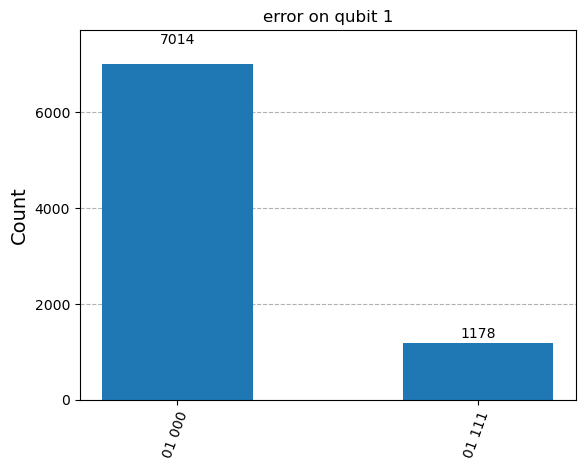

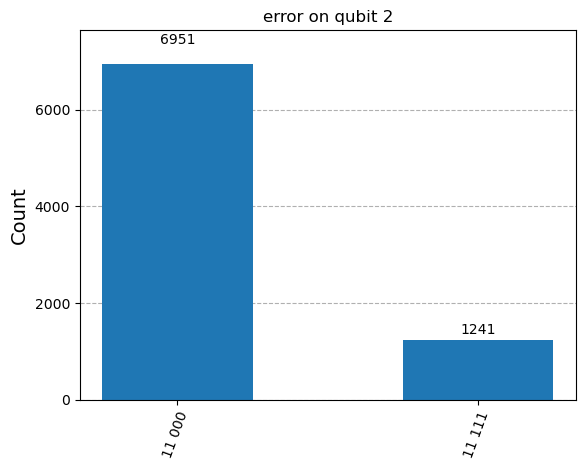

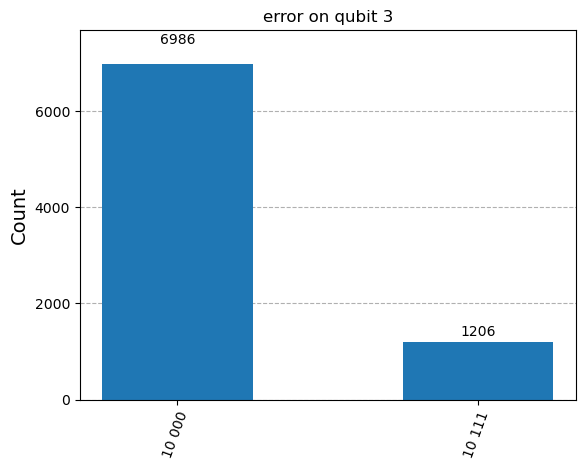

In [49]:
# fig,ax = plt.figure()

for test_qubit in range(3):
    fig,ax = plt.subplots()

    # generate bit-flip in one of the three qubits
    noise_circ = QuantumCircuit(cq,cb,pq,pb,eq)
    noise_circ.x(cq[test_qubit])

    # compose the circuit
    circuit = init_circ.compose(noise_circ)
    circuit = circuit.compose(check_circ)
    circuit = circuit.compose(feedback_circ)
    circuit = circuit.compose(final_circ)

    # Simulate your circuit. 2**13 shots should be sufficient
    transpiled_circuit = transpile(circuit, backend_qasm)
    job = backend_qasm.run(transpiled_circuit, shots=2**13)
    # Get results using the .result().get_counts() function
    counts = job.result().get_counts()
    # Plot the histogram using the plot_histogram function
    plot_histogram(counts, ax=ax)
    ax.set_title('error on qubit %d'%(test_qubit+1))

### Part 3: Repetition code under the bit-flip channel

Now we have a code and we have a channel, so let's put them together! we will apply the channel to the three code qubits after they are initialized to the code state $\alpha \vert 000 \rangle + \beta \vert 111 \rangle$, and again we set $\alpha=cos(\pi /8)$ and $\beta=sin(\pi /8)$.

We will reuse most of the circuit gadgets from part 2, but we have to adapt the code for the bit-flip channel. We will introduce three environment qubits "eq" corresponding to the three code qubits "cq", and we will implement three independent bit-flip channel in parallel.

3(a) implement three independent bit-flip channel. This should copy & paste plus simple modification

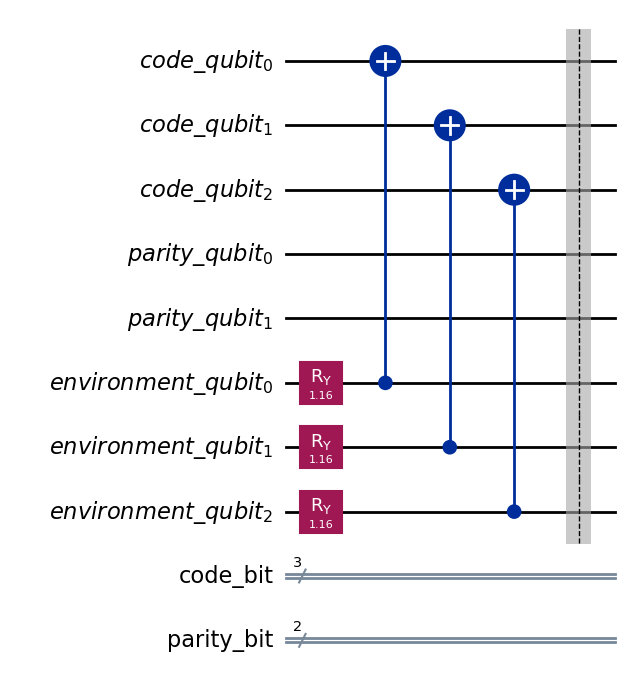

In [55]:
# again we will set p=0.3 for now
p = 0.3
error_circ = QuantumCircuit(cq,cb,pq,pb,eq)

###### implement the channel here ######

angle = math.asin(math.sqrt(p))
error_circ.ry(2*angle,eq[0])
error_circ.ry(2*angle,eq[1])
error_circ.ry(2*angle,eq[2])
error_circ.cx(eq[0],cq[0])
error_circ.cx(eq[1],cq[1])
error_circ.cx(eq[2],cq[2])



########################################
error_circ.barrier()

error_circ.draw('mpl')

We are pretty much all set! Run the code below to visualize the full circuit 

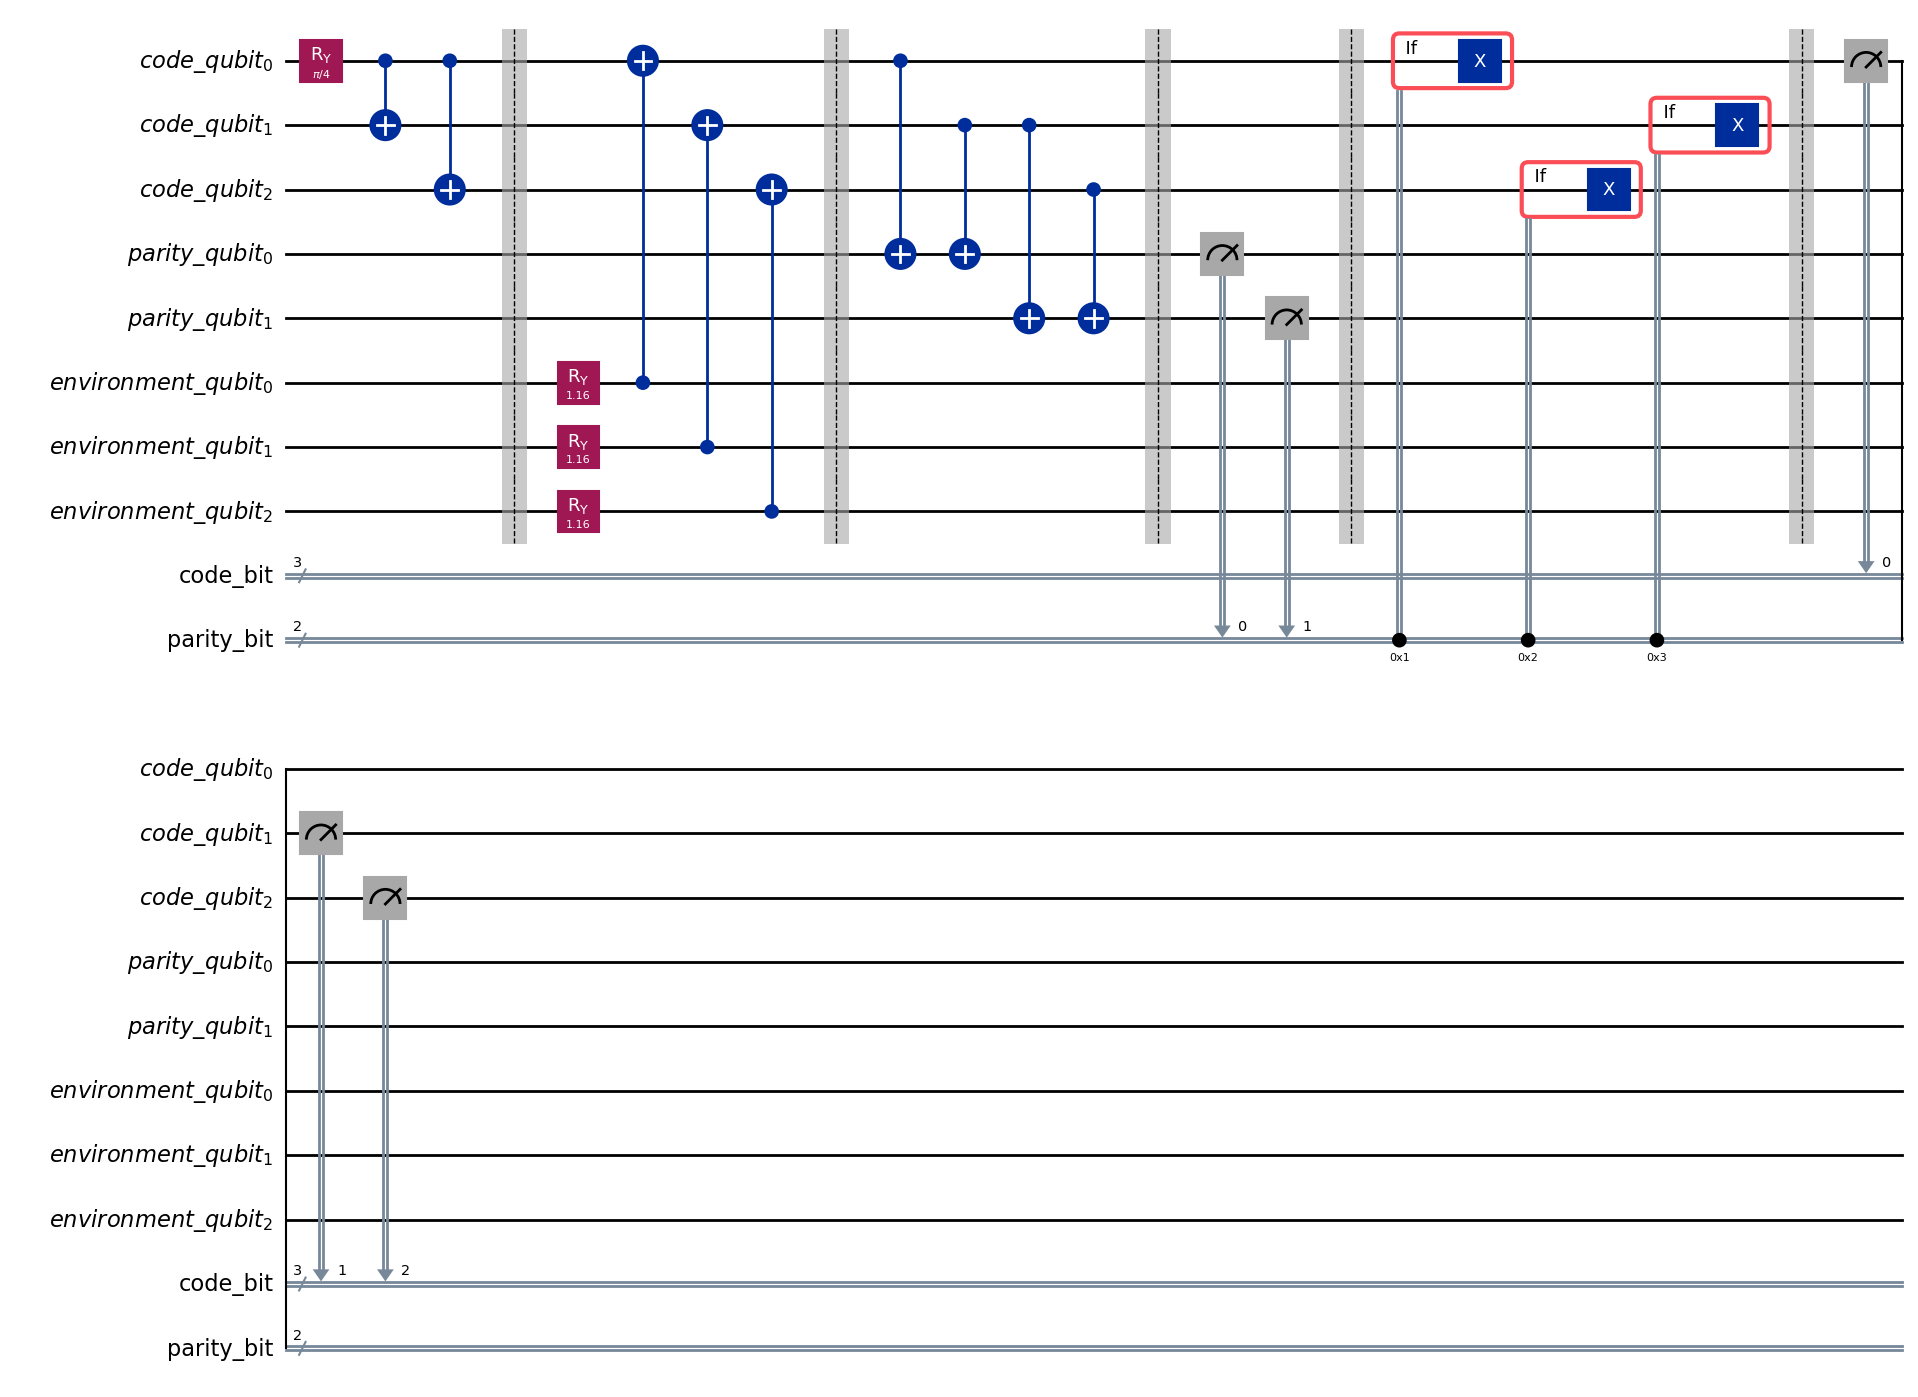

In [56]:
# compose the circuit
circuit = init_circ.compose(error_circ)
circuit = circuit.compose(check_circ)
circuit = circuit.compose(feedback_circ)
circuit = circuit.compose(final_circ)

circuit.draw('mpl')

And we will run the circuit with p=0.3. This time because all three qubits are independently flipped, there will be a finite probability that the code fails, and you should see that the ratio between 000 and 111 looks odd! This means for some experiments more than one bit are flipped, and our code cannot correct for it.

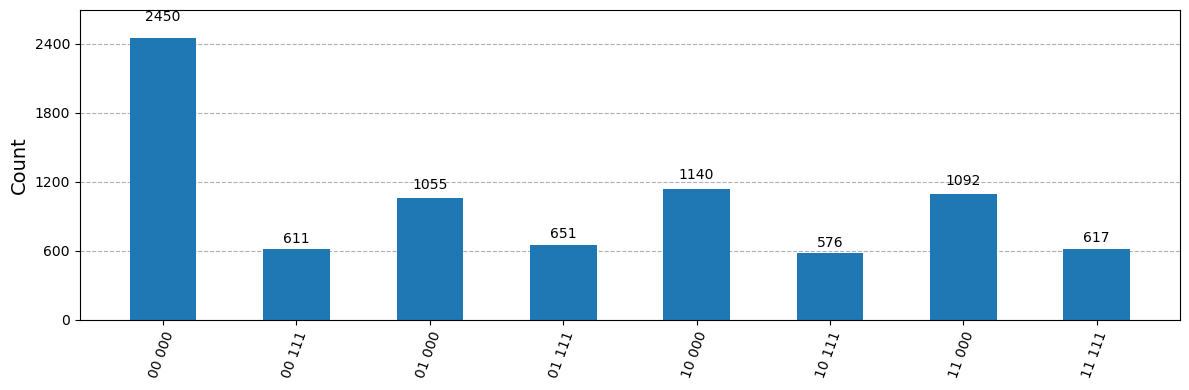

In [57]:
# Simulate your circuit. 2**13 shots should be sufficient
transpiled_circuit = transpile(circuit, backend_qasm)
job = backend_qasm.run(transpiled_circuit, shots=2**13)
# Get results using the .result().get_counts() function
counts = job.result().get_counts()
# Plot the histogram using the plot_histogram function
plot_histogram(counts, figsize=(12, 4))

We would like to quantify this offset in the final measurement probability, so we will scan the value of p and look at how P(000), the probability of getting $\vert 000 \rangle$, changes with the the bit-flip probability p.

3(b) Scan the value of p from 0 to 0.3 and plot the value of P(000), normalized to the value without the noise (this is essentially calculating state fidelity).

Hint: once you know your code is working, you can set shots to 2^16 to reduce statistical fluctuations. I have sample 30 value of p and use 2^16 shots and it takes me 2 minutes to run the code

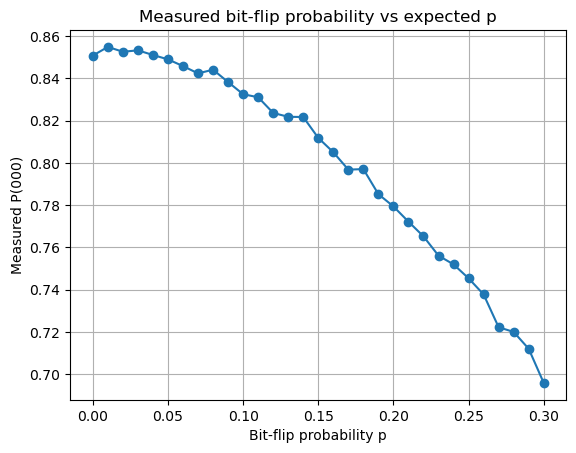

In [54]:
####### reuse your code from before and scan p here #########

import matplotlib.pyplot as plt

def bit_flip_channel(angle):
    error_circ = QuantumCircuit(cq,cb,pq,pb,eq)
    ####### implement the channel here #########
    error_circ.ry(2*angle,eq[0])
    error_circ.ry(2*angle,eq[1])
    error_circ.ry(2*angle,eq[2])
    error_circ.cx(eq[0],cq[0])
    error_circ.cx(eq[1],cq[1])
    error_circ.cx(eq[2],cq[2])
    circuit = init_circ.compose(error_circ)
    circuit = circuit.compose(check_circ)
    circuit = circuit.compose(feedback_circ)
    circuit = circuit.compose(final_circ)

    return circuit

probs_1 = []
shots=2**15
p_values = np.linspace(0, 0.3, 31)
for p in p_values:
    theta = math.asin(math.sqrt(p))
    circuit = bit_flip_channel(theta)
    transpiled = transpile(circuit, backend_qasm)
    job = backend_qasm.run(transpiled, shots=shots)
    counts = job.result().get_counts()
    p1 = counts.get('00 000', 0) / shots
    p1 += counts.get('10 000', 0) / shots
    p1 += counts.get('11 000', 0) / shots
    p1 += counts.get('01 000', 0) / shots
    probs_1.append(p1)
plt.plot(p_values, probs_1, marker='o')
plt.xlabel("Bit-flip probability p")
plt.ylabel("Measured P(000)")
plt.title("Measured bit-flip probability vs expected p")
plt.grid()
plt.show()

If your code works as expected, you will notice that this plot looks very different from the plot you obtained from part 1, where there is no error correction! 

3(c) Describe how does P(000) change with the bit-flip rate p when p is low (Hint: it a simple power-law)? Why this relation is what you should expect for an error correcting code?

P(000) is relatively constant for small p becasue it is going to work perfectly unless there is a two or more bit flip which has probability p^2, but for small p this is neglible so we can say that all errors that will happen will be single qubit errors which are completely fixed by the error correction so p(000) is relatively constant.